In [1]:
# Copyright 2020 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

## Overview

NVTabular is a feature engineering and preprocessing library for tabular data designed to quickly and easily manipulate terabyte scale datasets used to train deep learning based recommender systems.  It provides a high level abstraction to simplify code and accelerates computation on the GPU using the RAPIDS cuDF library.<br><br>

### Learning Objectives

In this notebook, we show how to

- do preprocessing with NVTabular
- serialize and save a workflow to load later to transform new dataset
- train a TF MLP model and save it in the /models directory.
- save the ensemble model to be used at the deployment stage.

### MovieLens25M

The [MovieLens25M](https://grouplens.org/datasets/movielens/25m/) is a popular dataset for recommender systems and is used in academic publications. The dataset contains 25M movie ratings for 62,000 movies given by 162,000 users. Although we may not improve state-of-the-art results with our neural network architecture, the purpose of this notebook is to explain how to save an ensemble model which consists of NVTabular workflow and Tensorflow model to be used later at model deployment stage.

## Getting Started

In [1]:
import os, time
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

import tensorflow as tf

from tensorflow.python.feature_column import feature_column_v2 as fc

# we can control how much memory to give tensorflow with this environment variable
# IMPORTANT: make sure you do this before you initialize TF's runtime, otherwise
# TF will have claimed all free GPU memory
os.environ['TF_MEMORY_ALLOCATION'] = "0.6" # fraction of free memory
from nvtabular.loader.tensorflow import KerasSequenceLoader, KerasSequenceValidater
from nvtabular.framework_utils.tensorflow import layers
from tensorflow.python.feature_column import feature_column_v2 as fc

In [2]:
# External dependencies
import cudf                 # cuDF is an implementation of Pandas-like Dataframe on GPU
import time
import gc

import pandas as pd
import nvtabular as nvt

from os import path
from sklearn.model_selection import train_test_split

In [3]:
# path to store raw and preprocesses data
BASE_DIR = '/working_dir/data/'

We define our base directory, containing the data.

If the data is not available in the base directory, we will download and unzip the data.

In [5]:
if not path.exists(BASE_DIR + 'ml-25m'):
    if not path.exists(BASE_DIR + 'ml-25m.zip'):
        os.system("wget http://files.grouplens.org/datasets/movielens/ml-25m.zip")
        os.system("mv ml-25m.zip " + BASE_DIR)
    os.system("unzip " + BASE_DIR + "ml-25m.zip -d " + BASE_DIR)

## Preparing the dataset with NVTabular

First, we take a look on the movie metadata. 

We load the movie ratings.

In [6]:
ratings = cudf.read_csv(os.path.join(BASE_DIR, "ml-25m", "ratings.csv"))
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


We drop the timestamp column and split the ratings into training and test dataset. We use a simple random split.

In [7]:
ratings = ratings.drop('timestamp', axis=1)
train, valid = train_test_split(ratings, test_size=0.2, random_state=42)

In [8]:
train.head()

,userId,movieId,rating
19120594,124027,56587,4.0
15253127,98809,2641,2.5
12584278,81377,122886,4.5
18034326,116853,78499,4.5
18073299,117118,1302,2.5


In [9]:
train.shape

(20000076, 3)

First, we need to define our NVTabular processing pipelines. NVTabular has already implemented multiple calculations, called `ops`. An `op` can be applied to a `ColumnGroup` from an overloaded `>>` operator, which in turn returns a new `ColumnGroup`. A `ColumnGroup` is a list of column names as text.<br><br>
**Example:**<br>
features = [*\<column name\>*, ...] >> *\<op1\>* >> *\<op2\>* >> ...

Embedding Layers of neural networks require, that categorial features are continuous, incremental Integers: 0, 1, 2, ... , |C|-1. We need to ensure that our categorical features fullfil the requirement.<br>

We should transform the single-hot categorical features userId and movieId. NVTabular provides the operator `Categorify`, which provides this functionality with a high-level API out of the box.

Let's add `Categorify`  op for our categorical features, userId, movieId.

In [10]:
cat_names = ['userId', 'movieId']

cat_features = cat_names >> nvt.ops.Categorify(cat_cache="device")

The ratings are on a scale between 1-5. We want to predict a binary target with 1 are all ratings `>=4` and 0 are all ratings `<=3`. We use the [LambdaOp](https://github.com/NVIDIA/NVTabular/blob/main/nvtabular/ops/lambdaop.py) for it.

In [11]:
ratings = nvt.ColumnGroup(['rating']) >> (lambda col: (col>3).astype('int8'))

We can visualize our calculation graph.

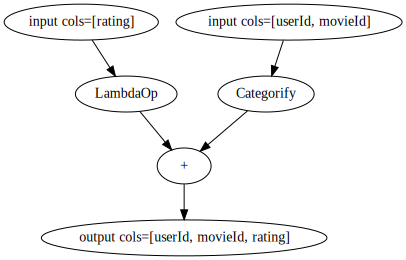

In [12]:
output = cat_features+ratings
(output).graph

We initialize our NVTabular `workflow`.

In [13]:
workflow = nvt.Workflow(output)

We save our train and valid datasets as parquet files on disk, and below we will read them in while initializing the Dataset objects.

In [14]:
train.to_parquet(BASE_DIR + 'train.parquet')
valid.to_parquet(BASE_DIR + 'valid.parquet')

In [15]:
del train
del valid
gc.collect()

17

We initialize NVTabular Datasets, and use the `part_size` parameter, which defines the size read into GPU-memory at once, in `nvt.Dataset`.

In [16]:
train_iter = nvt.Dataset(BASE_DIR + 'train.parquet', part_size='100MB')
valid_iter = nvt.Dataset(BASE_DIR + 'valid.parquet', part_size='100MB')

First, we collect the training dataset statistics.

In [17]:
%%time

workflow.fit(train_iter)

CPU times: user 1.13 s, sys: 440 ms, total: 1.57 s
Wall time: 1.62 s


We clear our output directories.

In [7]:
if path.exists(BASE_DIR + 'train'): 
    !rm -r $BASE_DIR/train
if path.exists(BASE_DIR + 'valid'): 
    !rm -r $BASE_DIR/valid

We transform our workflow with `.transform`.

In [19]:
%time

workflow.transform(train_iter).to_parquet(output_path=BASE_DIR + 'train/')
workflow.transform(valid_iter).to_parquet(output_path=BASE_DIR + 'valid/', shuffle=False)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


We can take a look in the output dir.

In [20]:
!ls $BASE_DIR/train

0.da19e14d23214af7b7e5ff8398fc7549.parquet  _metadata
_file_list.txt				    _metadata.json


## TensorFlow: Training Neural Network

### Reviewing data

We can take a look on the data.

In [21]:
import glob

TRAIN_PATHS = sorted(glob.glob(BASE_DIR + 'train/*.parquet'))
VALID_PATHS = sorted(glob.glob(BASE_DIR + 'valid/*.parquet'))
TRAIN_PATHS, VALID_PATHS

(['/working_dir/data/train/0.da19e14d23214af7b7e5ff8398fc7549.parquet'],
 ['/working_dir/data/valid/0.afdc01340ac14c6a815b77f2f6b3ba01.parquet'])

We can see that our ratings are of only 0 and 1 after preprocessing.

In [22]:
df = cudf.read_parquet(TRAIN_PATHS[0])
df.head()

,userId,movieId,rating
0,124027,11994,1
1,98809,2550,0
2,81377,24262,1
3,116853,14786,1
4,117118,1269,0


In [23]:
del df
gc.collect()

638

At this step we are going to generate config.pbtxt and we will save our workflow as a .pkl file to be able to load again to do transformation for the test (new coming) datasets at inference stage. This step actually does the serialization of the workflow that we created above using the training set.

In [24]:
# converts a workflow to a triton mode 

from nvtabular.inference.triton import generate_triton_model
generate_triton_model(workflow, "movielens_nvt", "/working_dir/tf_models/movielens_nvt/")

name: "movielens_nvt"
input {
  name: "userId"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
input {
  name: "movieId"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
input {
  name: "rating"
  data_type: TYPE_FP64
  dims: -1
  dims: 1
}
output {
  name: "userId"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
output {
  name: "movieId"
  data_type: TYPE_INT64
  dims: -1
  dims: 1
}
output {
  name: "rating"
  data_type: TYPE_INT8
  dims: -1
  dims: 1
}
backend: "python"

Now we will train a TF MLP model using our preprocessed parquet files.

### Defining Hyperparameters

First, we define the data schema, and define our single-hot categorical features. Note, that we do not have any numerical input features. 

In [25]:
BATCH_SIZE = 1024*32                            # Batch Size
CATEGORICAL_COLUMNS = ['movieId', 'userId']     # Single-hot
NUMERIC_COLUMNS = []

We get the embedding input and output dimensions.

We will use emb_dim 64 for each categorical features.

In [26]:
EMBEDDING_TABLE_SHAPES = {'movieId': (56586, 64), 'userId': (162542, 64)}

### Initializing NVTabular Data Loader for Tensorflow

First, we take a look on our data loader and how the data is represented as tensors. The NVTabular data loader are initialized and we specify single-hot categorical features as cat_names.

In [27]:
train_dataset_tf = KerasSequenceLoader(
    TRAIN_PATHS, # you could also use a glob pattern
    batch_size=BATCH_SIZE,
    label_names=['rating'],
    cat_names=CATEGORICAL_COLUMNS,
    cont_names=NUMERIC_COLUMNS,
    engine='parquet',
    shuffle=True,
    buffer_size=0.06, # how many batches to load at once
    parts_per_chunk=1
)

valid_dataset_tf = KerasSequenceLoader(
    VALID_PATHS, # you could also use a glob pattern
    batch_size=BATCH_SIZE,
    label_names=['rating'],
    cat_names = CATEGORICAL_COLUMNS,
    cont_names=NUMERIC_COLUMNS,
    engine='parquet',
    shuffle=False,
    buffer_size=0.06,
    parts_per_chunk=1
)

### Defining Neural Network Architecture

We will define a common neural network architecture for tabular data.
* Single-hot categorical features are fed into an Embedding Layer
* The output of the Embedding Layers are concatenated
* The concatenated layers are fed through multiple feed-forward layers (Dense Layers with ReLU activations)
* The final output is a single number with sigmoid activation function

First, we will define some dictonary/lists for our network architecture.

In [28]:
inputs = {}    # tf.keras.Input placeholders for each feature to be used
emb_layers = []# output of all embedding layers, which will be concatenated

We create `tf.keras.Input` tensors for all 4 input features.

In [29]:
for col in CATEGORICAL_COLUMNS:
    inputs[col] =  tf.keras.Input(
        name=col,
        dtype=tf.int32,
        shape=(1,)
    )

Next, we initialize Embedding Layers with `tf.feature_column.embedding_column`.

In [30]:
for col in CATEGORICAL_COLUMNS:

    emb_layers.append(
        tf.feature_column.embedding_column(
            tf.feature_column.categorical_column_with_identity(
                col, 
                EMBEDDING_TABLE_SHAPES[col][0]                    # Input dimension (vocab size)
            ), EMBEDDING_TABLE_SHAPES[col][1]                     # Embedding output dimension
        )
    )
emb_layers

[EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='movieId', number_buckets=56586, default_value=None), dimension=64, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f4677033040>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='userId', number_buckets=162542, default_value=None), dimension=64, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f46770330a0>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True)]

NVTabular implemented a custom TensorFlow layer `layers.DenseFeatures`, which takes as an input the different `tf.Keras.Input` and pre-initialized `tf.feature_column` and automatically concatenate them into a flat tensor. `DenseFeatures` can handle numeric inputs, as well, but MovieLens does not provide numerical input features.

In [31]:
emb_layer = layers.DenseFeatures(emb_layers)
x_emb_output = emb_layer(inputs)
x_emb_output

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_features')>

We can see that the output shape of the concatenated layer is equal to the sum of the individual Embedding output dimensions.


We add multiple Dense Layers. Finally, we initialize the `tf.keras.Model` and add the optimizer.

In [32]:
x = tf.keras.layers.Dense(128, activation='relu')(x_emb_output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile('sgd', 'binary_crossentropy')

### Training the deep learning model

We can train our model with `model.fit`.

In [33]:
validation_callback = KerasSequenceValidater(valid_dataset_tf)

history = model.fit(train_dataset_tf, callbacks=[validation_callback], epochs=3)

Epoch 1/3
611/611 [==============================] - 4s 5ms/step - loss: 0.6730
Epoch 2/3
611/611 [==============================] - 3s 5ms/step - loss: 0.6615
Epoch 3/3
611/611 [==============================] - 3s 5ms/step - loss: 0.6615


We can save the trained TF model

In [34]:
model.save('/working_dir/tf_models/movielens_tf/1/model.savedmodel')

INFO:tensorflow:Assets written to: /working_dir/tf_models/movielens_tf/1/model.savedmodel/assets


INFO:tensorflow:Assets written to: /working_dir/tf_models/movielens_tf/1/model.savedmodel/assets


In [35]:
import nvtabular
import tensorflow
workflow = nvtabular.Workflow.load("/working_dir/tf_models/movielens_nvt/1/workflow/")
workflow.output_dtypes["userId"] = "int32"
workflow.output_dtypes["movieId"] = "int32"
model = tf.keras.models.load_model("/working_dir/tf_models/movielens_tf/1/model.savedmodel")

In [36]:
# Creates an ensemble triton server model, where
#   model: The tensorflow model that should be served
#   workflow: The nvtabular workflow used in preprocessing
#   name: The base name of the various triton models

from nvtabular.inference.triton import export_tensorflow_ensemble
export_tensorflow_ensemble(model, workflow, "movielens", "/working_dir/models/", ["rating"])

INFO:tensorflow:Assets written to: /working_dir/models/movielens_tf/1/model.savedmodel/assets


INFO:tensorflow:Assets written to: /working_dir/models/movielens_tf/1/model.savedmodel/assets


In [37]:
# !apt-get install tree

Each model in a model repository must include a model configuration that provides required and optional information about the model. Next, Triton needs a config file to understand how to interpret the model.

In [40]:
!tree /working_dir/models/movielens

/working_dir/models/movielens
├── 1
└── config.pbtxt

1 directory, 1 file


A minimal model repository for a TensorFlow SavedModel model is:

In [41]:
!tree /working_dir/models/movielens_tf

/working_dir/models/movielens_tf
├── 1
│   └── model.savedmodel
│       ├── assets
│       ├── keras_metadata.pb
│       ├── saved_model.pb
│       └── variables
│           ├── variables.data-00000-of-00001
│           └── variables.index
└── config.pbtxt

4 directories, 5 files
